<a href="https://colab.research.google.com/github/oamerl/machine-learning-projects/blob/main/Deep-Learning/contract-nli/ContractNLI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Needed Libraries

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

import torch
! pip install -U accelerate
! pip install -U transformers
! pip install sentencepiece # needed for DeBerta-v2 model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

import pickle as pk

# the following code ensures that we can see print results for multiple tasks within a coding block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.3 MB/s eta 0:00:00


In this section we designed a function that takes a JSON formatted dataset and outputs the corresponsing dataframe with the option of saving the converted dataframe into a CSV file.

An example of the dataset format is given below. It is apparent that the json file contains a dictionary of 2 keys "documents" and "labels".

* The "documents" value itself is a list conating 1 dictionary and "labels" value is a dictionary of dictionaries.

* In "documents" dictionary we are interested in the following keys: "text" and "annotation_sets". The **"text"** is the contract which is a string which we are intrested in and "annotation_sets" is a list of 1 dictionary which has 1 key which is "annotations". The value of the "annotations" is another dictionary of dictionaries where the keys are the "nda" number and from the values we are only intrested in **"choice"** key which will have a value of either "Entailment", "NotMentioned" or "Contardiction".

* In "labels" dictionary each nested dictionary has a key indentifying the "nda" number and values of a "short_description" and **"hypothesis"**, from these both values we are interested only in the "hypothesis".

So to prepare our datasets for NLI task we will need the **"text"** of the contract and the NDA **"hypothesis"** and their corresponding **"choice"** which is the **"label"** indcating if the contract is satisfying the hypothesis or not. To extract this information from the JSON file we wrote a function as we mentioned previously and tried to comment the code to explain how we reached the final output. We also kept our thought process of reaching this function in the appendix section which shows the output of each step of the function.

This function was used to convert the training/validation/testing JSON files to dataframes and extract the previously mentioned needed data.

```
{
  "documents": [
    {
      "id": 1,
      "file_name": "example.pdf",
      "text": "NON-DISCLOSURE AGREEMENT\nThis NON-DISCLOSURE AGREEMENT (\"Agreement\") is entered into this ...",
      "document_type": "search-pdf",
      "url": "https://examplecontract.com/example.pdf",
      "spans": [
        [0, 24],
        [25, 89],
        ...
      ],
      "annotation_sets": [
        {
          "annotations": {
            "nda-1": {
              "choice": "Entailment",
              "spans": [
                12,
                13,
                91
              ]
            },
            "nda-2": {
              "choice": "NotMentioned",
              "spans": []
            },
            ...
          }
        }
      ]
    },
    ...
  ],
  "labels": {
    "nda-1": {
      "short_description": "Explicit identification",
      "hypothesis": "All Confidential Information shall be expressly identified by the Disclosing Party."
    },
    ...
  }
}
```



## Generating CSV files from JSON format

In [ ]:
def JSON_to_dataframe(json_file_path, to_csv_filename=None, to_csv=False):
    """ Converting a ContractNLI dataset JSON file to a pandas df """

    data = json.load(open(json_file_path)) # reading json file which is a dict of 2 keys "documents" and "labels"

    documents = pd.DataFrame(data['documents']) # getting the data of "documents" key
    nda_data = pd.DataFrame(data['labels']).transpose() # getting the value of the "labels" key whcij contains the NDA hypothesis

    # the data that we are concerned with are the "text" column and the "annotation_sets" column
    # "text" column is just containing strings
    # in the "annotation_sets" column each row value is a list of 1 item (hence [0]) where this item is a dict
    # this dict has only 1 key which is named "annotations" and we are seeking its value as it contains the nda-num and the choice
    documents['annotation'] = documents['annotation_sets'].apply(lambda annot_as_list: annot_as_list[0]['annotations'])

    # dropping unneeded columns from the dataframe
    columns_to_drop = list(documents.columns)
    columns_to_drop.remove('text') # needed
    columns_to_drop.remove('annotation') # needed
    documents_short = documents.drop(columns_to_drop ,  axis=1) # drop the rest of the columns

    # now the dataframe contains 2 columns the "text" column and the extracted "annotation" column
    # in this extracted column "annotation" itself each row is a dict where the keys are the nda number ("nda-num") and the values are also a dict containg the key "choice"
    # to expand the dataframe based on the keys inside the "annotation" column we will create another dataframe based on the "annotation" coulmn only
    # the made df1 will contain 2 columns which are the key "nda-num" and the value "nda_dict" of each dict in the "annotation" col hence each original row is now being expnaded by number of keys of each row dict
    df1 = (pd.DataFrame(documents_short['annotation'].values.tolist())).stack() # reshpae using stack
    df1 = df1.reset_index(level=1).rename(columns={0:'nda_dict', 'level_1':'nda-num'})

    # joining the made df1 with the original df documents_short and dropping the "annotation" column from it as it is no longer needed
    df2 = documents_short.drop('annotation', axis=1).join(df1).reset_index(drop=True)

    # here we are using the key "choice" to extract the value as data in "nda_dict" column are dicts
    df2['label'] = df2['nda_dict'].apply(lambda nda_dict: nda_dict['choice'])
    df2.drop(['nda_dict'], axis=1, inplace=True) # dropping the column as it is no longer needed

    # finally we need to merge the data in df2 which contains 3 columns "text", "nda-num", "label" with the nda-data df to get the corresponding hypothesis text for each nda-num
    nda_data = nda_data.reset_index(names=['nda-num']) # converting index of the df which is the nda-num to a column
    final_df = pd.merge(df2, nda_data, on = 'nda-num', how = 'left')
    final_df.drop(['nda-num', 'short_description'], axis=1, inplace=True) # dropping "nda-num" as it is no longer needed
    final_df = final_df[['text', 'hypothesis', 'label']] # just reordering the columns to put the label at the end

    if to_csv:
        final_df.to_csv(to_csv_filename, index=False)

    return final_df

    # to check the output of each step of this function please refer to the Appendix section

In [ ]:
training_df =  JSON_to_dataframe(json_file_path='/content/train.json', to_csv_filename="training_data.csv", to_csv=False)
validation_df = JSON_to_dataframe(json_file_path='/content/dev.json', to_csv_filename="validation_data.csv", to_csv=False)
testing_df = JSON_to_dataframe(json_file_path='/content/test.json', to_csv_filename="test_data.csv", to_csv=False)

In [ ]:
# checking if dataframe is in the desired format
training_df

,text,hypothesis,label
0,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,NotMentioned
1,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall destroy or return some C...,Entailment
2,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Agreement shall not grant Receiving Party any ...,Entailment
3,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not disclose the fact th...,Entailment
4,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Confidential Information shall only include te...,NotMentioned
...,...,...,...
7186,Exhibit (d)(3)\nNON-DISCLOSURE AGREEMENT\nThis...,Receiving Party may create a copy of some Conf...,NotMentioned
7187,Exhibit (d)(3)\nNON-DISCLOSURE AGREEMENT\nThis...,Receiving Party shall notify Disclosing Party ...,Entailment
7188,Exhibit (d)(3)\nNON-DISCLOSURE AGREEMENT\nThis...,Receiving Party may acquire information simila...,Entailment
7189,Exhibit (d)(3)\nNON-DISCLOSURE AGREEMENT\nThis...,Receiving Party may share some Confidential In...,Entailment


## Datasets Statistics

### Contracts Number Distribution across Datasets

<Axes: xlabel='Datasets'>

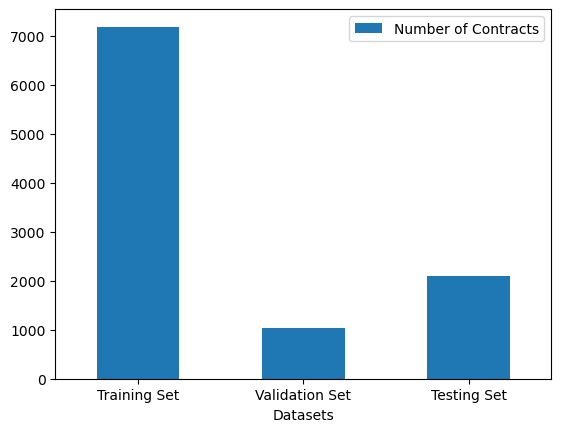

In [ ]:
# visualizing the number of contracts in each dataset

contracts_count_df = pd.DataFrame({'Datasets':['Training Set', 'Validation Set', 'Testing Set'], 'Number of Contracts':[training_df.shape[0], validation_df.shape[0], testing_df.shape[0]]})
contracts_count_df.plot.bar(x='Datasets', y='Number of Contracts', rot=0)

### Labels Distribution across Datasets

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 0, 'Training Set')

Text(0, 0.5, 'Label Count')

Text(0.5, 0, 'Validation Set')

Text(0, 0.5, 'Label Count')

Text(0.5, 0, 'Test Set')

Text(0, 0.5, 'Label Count')

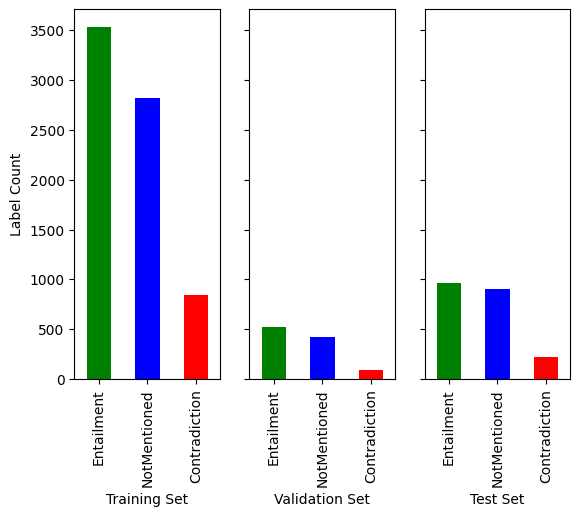

In [ ]:
# visualizing the the labels numbers in each dataset

fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex='all', sharey='all')
training_df["label"].value_counts().plot(kind = 'bar', ax=ax1, color=['green', 'blue', 'red']) # getting the count of different "rating" values
validation_df["label"].value_counts().plot(kind = 'bar', ax=ax2, color=['green', 'blue', 'red'])
testing_df["label"].value_counts().plot(kind = 'bar', ax=ax3, color=['green', 'blue', 'red'])

ax1.set_xlabel('Training Set') # renaming the x-axis
ax1.set_ylabel('Label Count') # renaming the y-axis

ax2.set_xlabel('Validation Set') # renaming the x-axis
ax2.set_ylabel('Label Count') # renaming the y-axis

ax3.set_xlabel('Test Set') # renaming the x-axis
ax3.set_ylabel('Label Count') # renaming the y-axis

plt.show()

# {'Entailment':'green', 'NotMentioned':'blue', 'Contradiction':'red'}

### Contracts Length Statistics across Datasets

In [ ]:
def words_per_contract(contracts):
    """ given a df of sentences "strings" it returns max,min and average number of words across the passed sentences"""

    contracts_lengths = []
    for contract in contracts:
        words_in_contract = contract.split()
        contracts_lengths.append(len(words_in_contract))

    max_words_per_contract = np.max(contracts_lengths)
    min_words_per_contract = np.min(contracts_lengths)
    average_words_per_contract = np.mean(contracts_lengths)
    return max_words_per_contract, min_words_per_contract, average_words_per_contract

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Maximum Contract Length')

Text(0, 0.5, 'Number of Words')

Text(0.5, 1.0, 'Minimum Contract Length')

Text(0, 0.5, 'Number of Words')

Text(0.5, 1.0, 'Average Contract Length')

Text(0, 0.5, 'Number of Words')

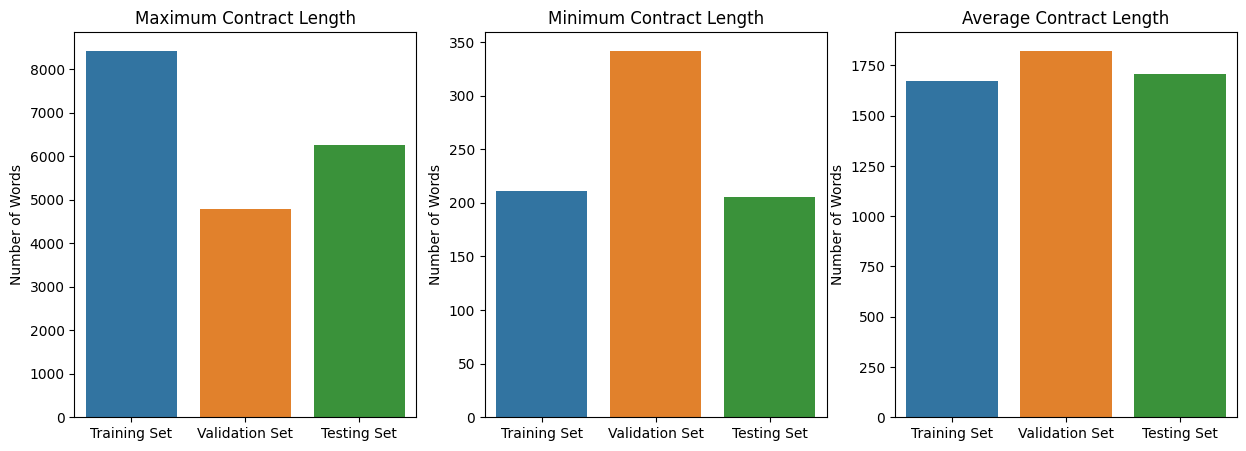

In [ ]:
# getting the max,min,mean number of words for the train,validation and testing data
max_words_per_train_sent, min_words_per_train_sent,  average_words_per_train_sent = words_per_contract(training_df['text'])
max_words_per_valid_sent, min_words_per_valid_sent,  average_words_per_valid_sent = words_per_contract(validation_df['text'])
max_words_per_test_sent, min_words_per_test_sent,  average_words_per_test_sent = words_per_contract(testing_df['text'])

# getting x and y for plotting
x = ['Training Set', 'Validation Set', 'Testing Set']
max_y = [max_words_per_train_sent, max_words_per_valid_sent, max_words_per_test_sent]
min_y = [min_words_per_train_sent, min_words_per_valid_sent, min_words_per_test_sent]
avg_y = [average_words_per_train_sent, average_words_per_valid_sent, average_words_per_test_sent]

fig, axes = plt.subplots(1,3,figsize=(15, 5))
sns.barplot(x=x, y=max_y, ax=axes[0])
sns.barplot(x=x, y=min_y, ax=axes[1])
sns.barplot(x=x, y=avg_y, ax=axes[2])
axes[0].set_title("Maximum Contract Length")
axes[0].set_ylabel("Number of Words")

axes[1].set_title("Minimum Contract Length")
axes[1].set_ylabel("Number of Words")

axes[2].set_title("Average Contract Length")
axes[2].set_ylabel("Number of Words")

plt.show()

### Contracts Length Statistics for Different Lables across Datasets

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Maximum Contract Length')

Text(0, 0.5, 'Number of Words')

Text(0.5, 1.0, 'Minimum Contract Length')

Text(0, 0.5, 'Number of Words')

Text(0.5, 1.0, 'Average Contract Length')

Text(0, 0.5, 'Number of Words')

Text(0, 0.5, 'Number of Words')

Text(0, 0.5, 'Number of Words')

Text(0, 0.5, 'Number of Words')

Text(0, 0.5, 'Number of Words')

Text(0, 0.5, 'Number of Words')

Text(0, 0.5, 'Number of Words')

Text(-9.0, 0, 'Training')

Text(-9.0, 0, 'Validation')

Text(-9.0, 0, 'Testing')

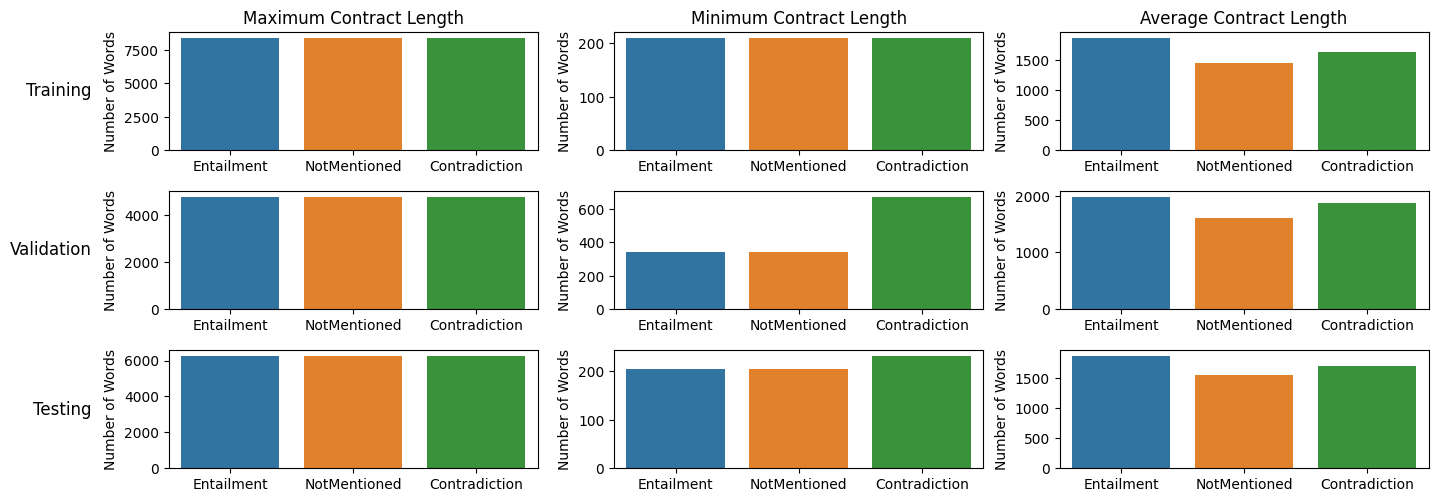

In [ ]:
# getting the data in case of the hypothesis label is "Entailment"
train_entailment = training_df[training_df['label'] == "Entailment"]
validation_entailment = validation_df[validation_df['label'] == "Entailment"]
testing_entailment = testing_df[testing_df['label'] == "Entailment"]

# getting the data in case of the hypothesis label is "NotMentioned"
train_NotMentioned = training_df[training_df['label'] == "NotMentioned"]
validation_NotMentioned = validation_df[validation_df['label'] == "NotMentioned"]
testing_NotMentioned = testing_df[testing_df['label'] == "NotMentioned"]

# getting the data in case of the hypothesis label is "Contradiction"
train_Contradiction = training_df[training_df['label'] == "Contradiction"]
validation_Contradiction = validation_df[validation_df['label'] == "Contradiction"]
testing_Contradiction = testing_df[testing_df['label'] == "Contradiction"]


# getting the max,min,mean number of words for the training data
max_words_per_train_entailment, min_words_per_train_entailment,  average_words_per_train_entailment = words_per_contract(train_entailment['text'])
max_words_per_train_NotMentioned, min_words_per_train_NotMentioned,  average_words_per_train_NotMentioned = words_per_contract(train_NotMentioned['text'])
max_words_per_train_Contradiction, min_words_per_train_Contradiction,  average_words_per_train_Contradiction = words_per_contract(train_Contradiction['text'])

# getting the max,min,mean number of words for the validation data
max_words_per_validation_entailment, min_words_per_validation_entailment,  average_words_per_validation_entailment = words_per_contract(validation_entailment['text'])
max_words_per_validation_NotMentioned, min_words_per_validation_NotMentioned,  average_words_per_validation_NotMentioned = words_per_contract(validation_NotMentioned['text'])
max_words_per_validation_Contradiction, min_words_per_validation_Contradiction,  average_words_per_validation_Contradiction = words_per_contract(validation_Contradiction['text'])

# getting the max,min,mean number of words for the testing data
max_words_per_testing_entailment, min_words_per_testing_entailment,  average_words_per_testing_entailment = words_per_contract(testing_entailment['text'])
max_words_per_testing_NotMentioned, min_words_per_testing_NotMentioned,  average_words_per_testing_NotMentioned = words_per_contract(testing_NotMentioned['text'])
max_words_per_testing_Contradiction, min_words_per_testing_Contradiction,  average_words_per_testing_Contradiction = words_per_contract(testing_Contradiction['text'])


# getting x and y for plotting
x = ['Entailment', 'NotMentioned', 'Contradiction']

max_y_train = [max_words_per_train_entailment, max_words_per_train_NotMentioned, max_words_per_train_Contradiction]
min_y_train = [min_words_per_train_entailment, min_words_per_train_NotMentioned, min_words_per_train_Contradiction]
avg_y_train = [average_words_per_train_entailment, average_words_per_train_NotMentioned, average_words_per_train_Contradiction]

max_y_valid = [max_words_per_validation_entailment, max_words_per_validation_NotMentioned, max_words_per_validation_Contradiction]
min_y_valid = [min_words_per_validation_entailment, min_words_per_validation_NotMentioned, min_words_per_validation_Contradiction]
avg_y_valid = [average_words_per_validation_entailment, average_words_per_validation_NotMentioned, average_words_per_validation_Contradiction]

max_y_test = [max_words_per_testing_entailment, max_words_per_testing_NotMentioned, max_words_per_testing_Contradiction]
min_y_test = [min_words_per_testing_entailment, min_words_per_testing_NotMentioned, min_words_per_testing_Contradiction]
avg_y_test = [average_words_per_testing_entailment, average_words_per_testing_NotMentioned, average_words_per_testing_Contradiction]

# Plotting
fig, axes = plt.subplots(3,3,figsize=(15, 5))
sns.barplot(x=x, y=max_y_train, ax=axes[0,0])
sns.barplot(x=x, y=min_y_train, ax=axes[0,1])
sns.barplot(x=x, y=avg_y_train, ax=axes[0,2])

sns.barplot(x=x, y=max_y_valid, ax=axes[1,0])
sns.barplot(x=x, y=min_y_valid, ax=axes[1,1])
sns.barplot(x=x, y=avg_y_valid, ax=axes[1,2])

sns.barplot(x=x, y=max_y_test, ax=axes[2,0])
sns.barplot(x=x, y=min_y_test, ax=axes[2,1])
sns.barplot(x=x, y=avg_y_test, ax=axes[2,2])

axes[0,0].set_title("Maximum Contract Length")
axes[0,0].set_ylabel("Number of Words")
axes[0,1].set_title("Minimum Contract Length")
axes[0,1].set_ylabel("Number of Words")
axes[0,2].set_title("Average Contract Length")
axes[0,2].set_ylabel("Number of Words")

axes[1,0].set_ylabel("Number of Words")
axes[1,1].set_ylabel("Number of Words")
axes[1,2].set_ylabel("Number of Words")

axes[2,0].set_ylabel("Number of Words")
axes[2,1].set_ylabel("Number of Words")
axes[2,2].set_ylabel("Number of Words")

rows = ['Training', 'Validation', 'Testing']
pad = 5 # in points
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)
plt.show()

### Hypothesis length Statistics

<Axes: >

Text(0.5, 1.0, 'Hypothesis Length Stats')

Text(0, 0.5, 'Number of Words')

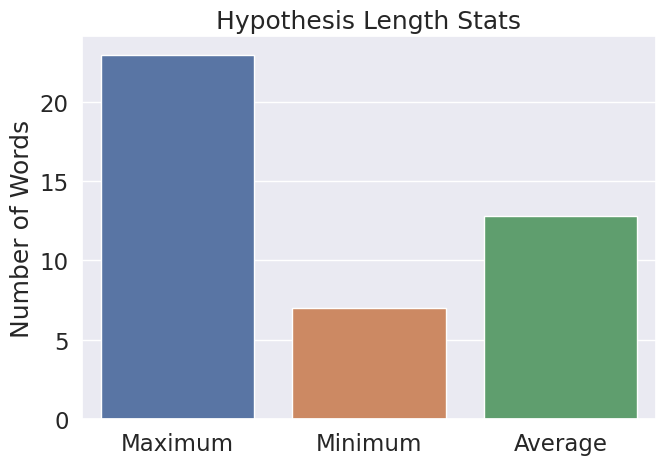

In [ ]:
# getting the max,min,mean number of words for the train data which is also the same for the validation and testing data
max_words_per_train_sent, min_words_per_train_sent,  average_words_per_train_sent = words_per_contract(training_df['hypothesis'])

# getting x and y for plotting
x = ['Maximum', 'Minimum', 'Average']
y = [max_words_per_train_sent, min_words_per_train_sent, average_words_per_train_sent]

fig, axes = plt.subplots(1,1,figsize=(7, 5))
sns.barplot(x=x, y=y, ax=axes)
axes.set_title("Hypothesis Length Stats")
axes.set_ylabel("Number of Words")

plt.tight_layout()
plt.show()


# Modeling: Fine tuning and Evaluation


## Utility Functions

In [ ]:
def max_seq_length(sentences, tokenizer):
    """Performing one tokenization pass of the dataset in order to measure the maximum sentence length."""

    max_len = 0

    # For every sentence...
    for sent in sentences:

        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.tokenize(sent)

        # Update the maximum sentence length.
        max_len = max(max_len, len(input_ids))

    return max_len

In [ ]:
def tokenize_data(data, tokenizer, max_len=512):
    """ Given a dataframe containg 'text' feature it will tokenize it acccording to the passed tokenizer"""

    return tokenizer(text=data['text'].tolist(),
                     text_pair=data['hypothesis'].tolist(),
                     truncation=True,
                     padding="max_length",
                     max_length=max_len)

In [ ]:
# a class to be used to instaniate our datasets to be Pytorch compatible
class ContractNLIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()} # value is a list
        item['labels'] = torch.tensor(int(self.labels[idx])) # setting the label as an integer tensor
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def compute_metrics(p):
    """ Function to be passed to the Pytorch 'Trainer' to evaluate the included the metrics """

    preds = np.argmax(p.predictions, axis=1)
    true_labels = p.label_ids

    accuracy = (preds == true_labels).mean()
    f1score = f1_score(true_labels,preds, average = 'macro')
    precision = precision_score(true_labels,preds, average = 'macro' )
    recall = recall_score(true_labels,preds, average = 'macro' )

    return {"accuracy": accuracy,
           "F1-Score": f1score,
           "Precision": precision,
           "Recall": recall}


! mkdir results # creating output directory for the model_trainer TrainingArguments function
! mkdir logs # creating logs directory for the model_trainer TrainingArguments function


def model_trainer(model, tokenizer, compute_metrics_func=compute_metrics, lr=5e-5, epochs_num=3):
    """ Given a model and a tokenizer the function uses Pytorch's 'TrainingArguments' and 'Trainer' functions to train the model"""

    training_args = TrainingArguments(
        output_dir='./results', # "./results" for colab and '/kaggle/working/results' for kaggle
        overwrite_output_dir=True,
        num_train_epochs=epochs_num,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        warmup_steps=500,
        learning_rate=lr,
        weight_decay=0.01,
        logging_dir='./logs',  # "./logs" for colab and '/kaggle/working/logs' for kaggle
        logging_steps=10,
        evaluation_strategy="epoch",
        report_to = 'none')

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_func, # applied on validation data
        )

    return trainer


## Model 1 - DeBERTa (base)

In [ ]:
model_name = "microsoft/deberta-base"

# model tokenizer
deberta_tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
print(model_name + " vocabulary size is:", len(deberta_tokenizer.vocab), 'tokens')

microsoft/deberta-base vocabulary size is: 50265 tokens


In [ ]:
print('Training max sentence length: ', max_seq_length(training_df['text'], deberta_tokenizer))
print('Validation max sentence length: ', max_seq_length(validation_df['text'], deberta_tokenizer))

Token indices sequence length is longer than the specified maximum sequence length for this model (1778 > 512). Running this sequence through the model will result in indexing errors


Training max sentence length:  11963
Validation max sentence length:  6566


Encoding the target hypothesis label

In [ ]:
for df in [training_df, validation_df, testing_df]:
    df['labels_id'] = df['label'].map({"NotMentioned": 0,
                                       "Entailment": 1,
                                       "Contradiction": 2})

train_labels = training_df['labels_id'].tolist()
valid_labels = validation_df['labels_id'].tolist()
test_labels = testing_df['labels_id'].tolist()

As we have seen the maximum sentence length of the training "text" after tokenization is ~12K token which is beyond the RAM size so we'll need to truncate the texts.

Unfortuantely we couldn't exceed 512 as a max length given to the tokenizer as having a longer length beyond this causes RAM crashes.

Later we will see that this severe truncation has a bad effect on the model and leads to bad performance.

In [ ]:
train_encodings = tokenize_data(training_df, deberta_tokenizer,max_len=512)
valid_encodings = tokenize_data(validation_df, deberta_tokenizer, max_len=512)
test_encodings = tokenize_data(testing_df, deberta_tokenizer, max_len=512)

Converting the datasets to be Pytorch compatible

In [ ]:
train_dataset = ContractNLIDataset(train_encodings, train_labels)
valid_dataset = ContractNLIDataset(valid_encodings, valid_labels)
test_dataset =  ContractNLIDataset(test_encodings, test_labels)

### DeBERTa model fine tuning

In [ ]:
deberta_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Model 1: DeBERTa-base, num_epochs=3, max_length=512
deberta_trainer = model_trainer(model = deberta_model,
                                tokenizer= deberta_tokenizer,
                                epochs_num=3)
deberta_trainer.train()

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classi

Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,0.618300,0.691667,0.675024,0.620041,0.616906,0.647616
2,0.659400,0.725194,0.700096,0.654164,0.645798,0.682437
3,0.607100,0.656612,0.709740,0.666444,0.649210,0.701978


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=2697, training_loss=0.6864672900572237, metrics={'train_runtime': 2276.423, 'train_samples_per_second': 9.477, 'train_steps_per_second': 1.185, 'total_flos': 6614280971596800.0, 'train_loss': 0.6864672900572237, 'epoch': 3.0})

Model Evaluation on Testing Dataset

In [ ]:
deberta_test_results = deberta_trainer.predict(test_dataset)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Saving the test results for later usage

In [ ]:
# Saving evaluation result to a pickle file for later usage
with open('test_results_Deberta_3epochs_512maxlength.pkl', 'wb') as f:  # open a file
    pk.dump(deberta_test_results, f) # serialize the list
f.close()

In [ ]:
# # Reading saved data
# with open('test_results_Deberta_3epochs_512maxlength.pkl', 'rb') as f:
#     deberta_test_results = pk.load(f) # deserialize using load()
# f.close()

Printing the classification results and true label ids as well as the evaluation metrics on testing set

In [ ]:
deberta_test_results.predictions
print("\n")
deberta_test_results.label_ids
print("\n")
deberta_test_results.metrics

array([[ 2.7480114 ,  0.48800087, -2.9540653 ],
       [ 2.3338823 ,  1.7718947 , -3.4404995 ],
       [ 1.004358  ,  2.6883075 , -2.9896817 ],
       ...,
       [ 0.7456409 ,  2.9977632 , -3.0162826 ],
       [-0.6505321 ,  3.075117  , -1.7278374 ],
       [-0.54314405,  3.1660674 , -1.9078596 ]], dtype=float32)

array([0, 1, 1, ..., 1, 1, 1])

{'test_loss': 0.6380693912506104,
 'test_accuracy': 0.7159253945480631,
 'test_F1-Score': 0.6749111384393386,
 'test_Precision': 0.6647588135321706,
 'test_Recall': 0.6930101376190171,
 'test_runtime': 75.5199,
 'test_samples_per_second': 27.688,
 'test_steps_per_second': 3.469}

To obtain the predicted label we'll use "argmax" function to get the label of  the highest value

In [ ]:
predictions = np.argmax(deberta_test_results.predictions, axis=1)

In [ ]:
predictions

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:
# testing_df["labels_id"] = deberta_test_results.label_ids
# testing_df["predicted_labels"] = predictions
# testing_df

,text,hypothesis,label,labels_id,predicted_labels
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,0,0
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,1,0
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,1,1
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,0,0
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,2,2
...,...,...,...,...,...
2086,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may create a copy of some Conf...,NotMentioned,0,0
2087,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party shall notify Disclosing Party ...,Entailment,1,1
2088,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may acquire information simila...,Entailment,1,1
2089,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may share some Confidential In...,Entailment,1,1


### DeBERTa Convergence Curves

In [ ]:
metrics_dict = {"Epoch" : [1,2,3],
                "Training Loss": [0.618300, 0.659400, 0.607100] ,
                "Validation Loss": [0.691667, 0.725194, 0.656612],
                "Validation Accuracy": [0.675024, 0.700096, 0.709740],
                "Validation F1-score": [0.620041, 0.654164, 0.666444],
                "Validation Precision" : [0.616906, 0.645798, 0.649210] ,
                "Validation Recall": [0.647616, 0.682437, 0.701978],
}

# Create a DataFrame from our training statistics and validation results
df_stats = pd.DataFrame(metrics_dict)
df_stats.set_index("Epoch") # Use the 'epoch' as the row index.

# Display the table.
# df_stats

,Training Loss,Validation Loss,Validation Accuracy,Validation F1-score,Validation Precision,Validation Recall
Epoch,,,,,,
1,0.6183,0.691667,0.675024,0.620041,0.616906,0.647616
2,0.6594,0.725194,0.700096,0.654164,0.645798,0.682437
3,0.6071,0.656612,0.709740,0.666444,0.649210,0.701978


Text(0.5, 1.0, 'DeBERTa Training & Validation Loss')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

([<matplotlib.axis.XTick at 0x79f7d0dae920>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3')])

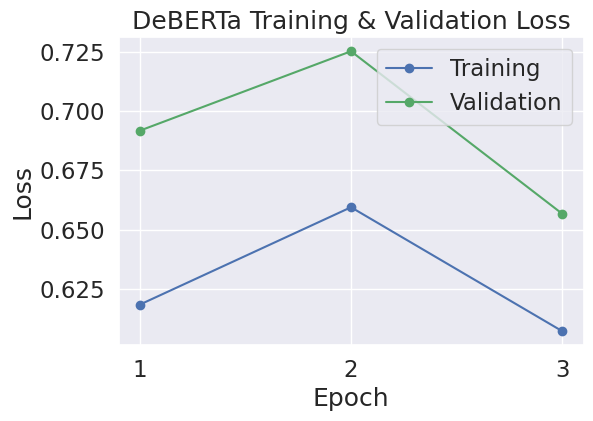

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (6,4)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("DeBERTa Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([0, 1, 2], labels=[1,2,3])

plt.show()

Plotting Classification Metrics versus Epochs

<Axes: >

Text(0.5, 1.0, 'DeBERTa Validation Metrics')

Text(0.5, 0, 'Epoch')

([<matplotlib.axis.XTick at 0x79f7d0e1e4a0>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3')])

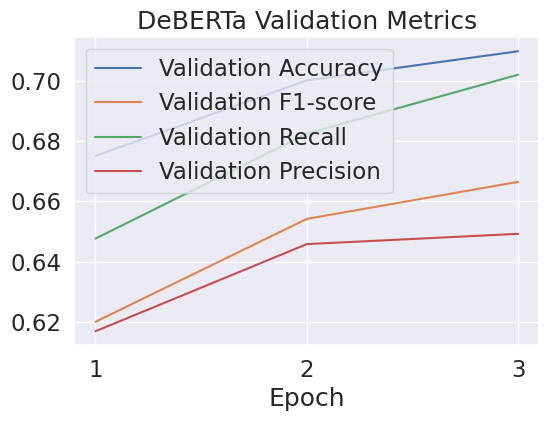

In [ ]:
df_stats.plot( y=["Validation Accuracy", "Validation F1-score", "Validation Recall", "Validation Precision"])
plt.title("DeBERTa Validation Metrics")
plt.xlabel("Epoch")
plt.xticks([0, 1, 2], labels=[1,2,3])
plt.show()

From the training/validation loss curves it seems that the model still can be fine tuned for more than 3 epochs as the training and validation loss keeps decreasing so it is worthy of trying to fine tune for a few more epochs and check the performance.

What also encourages trying to further fine tune the model for more than 3 epochs is that it is apparent that the metrics keeps improving with the number of epochs. However for the time being we stopped at the 3rd epoch.

## Model 2 - DistilBERT (base-uncased)

In [ ]:
model_name = "distilbert-base-uncased"

# model tokenizer
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
print(model_name + " vocabulary size is:", len(distilbert_tokenizer.vocab), 'tokens')

distilbert-base-uncased vocabulary size is: 30522 tokens


Encoding the target hypothesis label

In [ ]:
for df in [training_df, validation_df, testing_df]:
    df['labels_id'] = df['label'].map({"NotMentioned": 0,
                                       "Entailment": 1,
                                       "Contradiction": 2})

train_labels = training_df['labels_id'].tolist()
valid_labels = validation_df['labels_id'].tolist()
test_labels = testing_df['labels_id'].tolist()

Similar to what we have done previously with Model 1 tokenizer here we also set the max length to 512 as having a longer sequence length beyond this causes RAM crashes although the average training sequence length is ~1700 with a maximum of ~9000 which will increase after tokenization.

Later we will see that this severe truncation has a bad effect on the model and leads to bad performance.

In [ ]:
train_encodings = tokenize_data(training_df, distilbert_tokenizer,max_len=512)
valid_encodings = tokenize_data(validation_df, distilbert_tokenizer, max_len=512)
test_encodings = tokenize_data(testing_df, distilbert_tokenizer, max_len=512)

Converting the datasets to be Pytorch compatible

In [ ]:
train_dataset = ContractNLIDataset(train_encodings, train_labels)
valid_dataset = ContractNLIDataset(valid_encodings, valid_labels)
test_dataset =  ContractNLIDataset(test_encodings, test_labels)

### DistlBERT model fine tuning

In [ ]:
distilbert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Model 2: DistilBERT (base-uncased), num_epochs=4, max_length=512
distilbert_trainer = model_trainer(model = distilbert_model,
                                tokenizer= distilbert_tokenizer,
                                epochs_num=4)

distilbert_trainer_output = distilbert_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,0.964800,0.934268,0.511090,0.340751,0.331976,0.362845
2,0.861100,0.936914,0.500482,0.222365,0.166827,0.333333
3,0.787600,0.760769,0.682739,0.635417,0.622658,0.654892
4,1.019400,0.711896,0.709740,0.664801,0.670374,0.662673


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
distilbert_trainer

Model Evaluation on Testing Dataset

In [ ]:
distilbert_test_results = distilbert_trainer.predict(test_dataset)

Saving the test results for later usage

In [ ]:
# Saving evaluation result to a pickle file for later usage
with open('test_results_distilbert_4epochs512maxlen.pkl', 'wb') as f:  # open a file
    pk.dump(distilbert_test_results, f) # serialize the list
f.close()

In [ ]:
# # Reading saved data
# with open('test_results_distilbert_4epochs512maxlen.pkl', 'rb') as f:
#     distilbert_test_results = pk.load(f) # deserialize using load()
# f.close()

Printing the classification results and true label ids as well as the evaluation metrics on testing set

In [ ]:
distilbert_test_results.predictions
print("\n")
distilbert_test_results.label_ids
print("\n")
distilbert_test_results.metrics

array([[ 2.288966  , -0.20065686, -2.208835  ],
       [ 1.818468  ,  0.03583536, -2.0828633 ],
       [-0.27117807,  2.1417477 , -1.7605114 ],
       ...,
       [-0.42641267,  2.2353754 , -1.7342427 ],
       [-0.4581638 ,  2.2474186 , -1.7253758 ],
       [-0.45771468,  2.247227  , -1.7269242 ]], dtype=float32)

array([0, 1, 1, ..., 1, 1, 1])

{'test_loss': 0.7579053044319153,
 'test_accuracy': 0.6824485891917743,
 'test_F1-Score': 0.6371431724019602,
 'test_Precision': 0.6538013415105716,
 'test_Recall': 0.6298039287468463,
 'test_runtime': 37.3042,
 'test_samples_per_second': 56.053,
 'test_steps_per_second': 14.02}

To obtain the predicted label we'll use "argmax" function to get the label of  the highest value

In [ ]:
distilbert_predictions = np.argmax(distilbert_test_results.predictions, axis=1)

In [ ]:
distilbert_predictions

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:
# testing_df["labels_id"] = distilbert_test_results.label_ids
# testing_df["distilbert_predicted_labels"] = distilbert_predictions
# testing_df

,text,hypothesis,label,labels_id,predicted_labels
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,0,0
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,1,0
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,1,1
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,0,0
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,2,2
...,...,...,...,...,...
2086,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may create a copy of some Conf...,NotMentioned,0,0
2087,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party shall notify Disclosing Party ...,Entailment,1,1
2088,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may acquire information simila...,Entailment,1,1
2089,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may share some Confidential In...,Entailment,1,1


### DistilBERT Convergence Curves

In [ ]:
distilbert_metrics_dict = {"Epoch" : [1,2,3,4],
                "Training Loss": [0.964800, 0.861100, 0.787600, 1.019400] ,
                "Validation Loss": [0.934268, 0.936914, 0.760769, 0.711896],
                "Validation Accuracy": [0.511090, 0.500482, 0.682739, 0.709740],
                "Validation F1-score": [0.340751, 0.222365, 0.635417, 0.664801],
                "Validation Precision" : [0.331976, 0.166827, 0.622658, 0.670374] ,
                "Validation Recall": [0.362845, 0.333333, 0.654892, 0.66267],
}

# Create a DataFrame from our training statistics and validation results
df_stats_distilbert = pd.DataFrame(distilbert_metrics_dict)
df_stats_distilbert.set_index("Epoch") # Use the 'epoch' as the row index.

# Display the table.
# df_stats_distilbert

,Training Loss,Validation Loss,Validation Accuracy,Validation F1-score,Validation Precision,Validation Recall
Epoch,,,,,,
1,0.9648,0.934268,0.511090,0.340751,0.331976,0.362845
2,0.8611,0.936914,0.500482,0.222365,0.166827,0.333333
3,0.7876,0.760769,0.682739,0.635417,0.622658,0.654892
4,1.0194,0.711896,0.709740,0.664801,0.670374,0.662670


Text(0.5, 1.0, 'DistilBERT Training & Validation Loss')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

([<matplotlib.axis.XTick at 0x79f7cf299de0>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

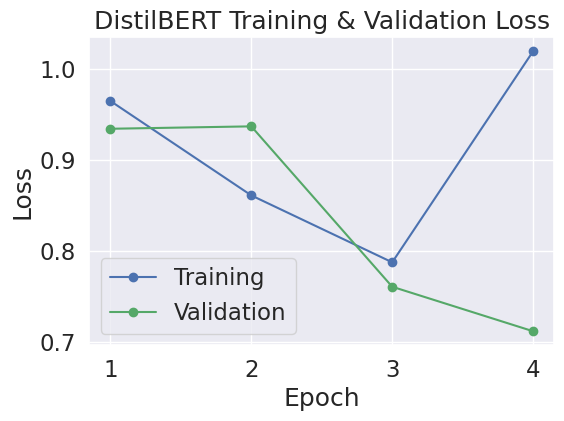

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (6,4)

# Plot the learning curve.
plt.plot(df_stats_distilbert['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats_distilbert['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("DistilBERT Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([0, 1, 2, 3], labels=[1,2,3,4])

plt.show()

Plotting Classification Metrics versus Epochs

<Axes: >

Text(0.5, 1.0, 'DistilBERT Validation Metrics')

Text(0.5, 0, 'Epoch')

([<matplotlib.axis.XTick at 0x79f7cf31c580>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

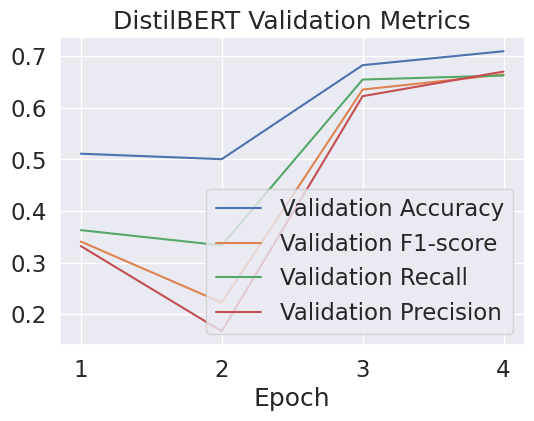

In [ ]:
df_stats_distilbert.plot( y=["Validation Accuracy", "Validation F1-score", "Validation Recall", "Validation Precision"])
plt.title("DistilBERT Validation Metrics")
plt.xlabel("Epoch")
plt.xticks([0, 1, 2, 3], labels=[1,2,3,4])
plt.show()

From the training/validation loss curves it seems that the model performance starts to get worse on the training set after epoch 3 as the training loss starts to increase so we should just stop fine tuning the model after 3 epochs which was also advised by the authors of BERT to fine tune up to 4 epochs only.

It is apparent that the metrics keeps increasing with the number of epochs but since improvements are not that significant from epoch 3 we guess 3 epochs is the optimal number.

## Models Testing Results Comparison

In [ ]:
# DeBERTa model testing metrics results
df1 = pd.DataFrame(deberta_test_results.metrics, index=range(8))
df2 = df1.T
df2.drop([1,2,3,4,5,6,7],axis=1, inplace=True)
df2.columns = ["DeBERTa Model"]

# DistilBERT model testing metrics results
df3 = pd.DataFrame(distilbert_test_results.metrics, index=range(8))
df4 = df3.T
df4.drop([1,2,3,4,5,6,7],axis=1, inplace=True)
df4.columns = ["DistilBERT Model"]

# concatination into a single dataframe
df = pd.concat([df2, df4], axis=1)
df = df.iloc[:-3, :]
df

,DeBERTa Model,DistilBERT Model
test_loss,0.638069,0.757905
test_accuracy,0.715925,0.682449
test_F1-Score,0.674911,0.637143
test_Precision,0.664759,0.653801
test_Recall,0.693010,0.629804


<Axes: >

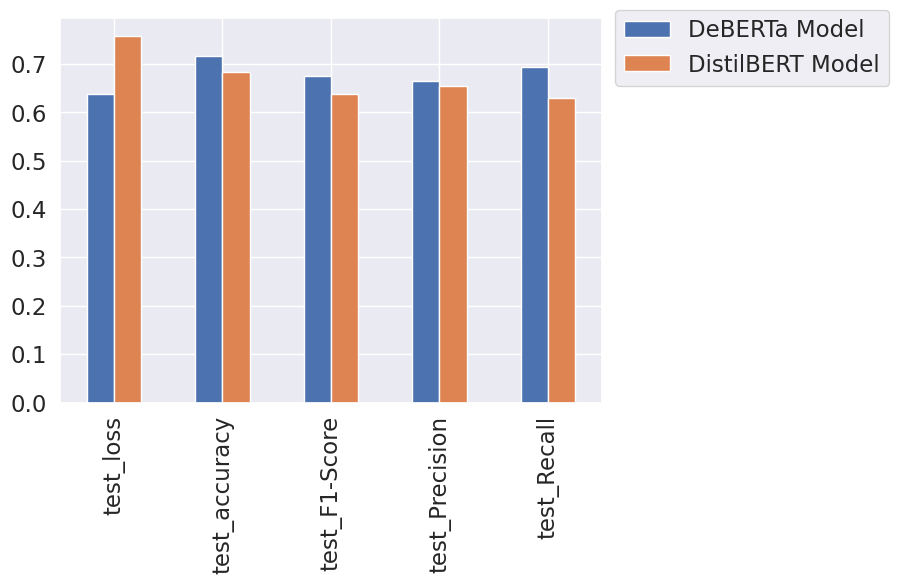

In [ ]:
df.plot.bar(figsize=(7,5),) #secondary_y= 'Hypothesis Average Length',  title = 'DistilBERT Average Lengths Distribution')
plt.legend(loc='upper right',  bbox_to_anchor = (0.5,1, 1.05,0.05))


From the above figure we can see that the DeBERTa model is having better performance than DistilBERT across all metrics, this is consistent with DeBERTa superiority over DistilBERT due to DeBERTa's model optimizations, combined with its the larger pre-trained model, which give it an advantage over DistilBERT for NLI task.

# Error Analysis














In this section we will perfrom error analysis for our 2 models with a goal of understanding what are the potential reasons behind the errors.

Errors in classification can result due to multiple reasons:

1.   No enough samples in the training data for a specific label which will result  in more misclassifications for this label. (Bias in the training data).
2.   The sequences length is either too big such that the evidence spans will come later in the sequence and be truncated and therefore the model will not see the relevant keywords for this specific label that will facilitate the classification or the sequence is too short and not carrying enough information.
3.   The training (fine tuning) is not done for the appropriate number of epochs.
4.   Domain mismatch. The NLI model used may be trained on a dataset of text that is different from the text that it is being asked to classify. This can lead to misclassification, as the model may not be familiar with the vocabulary or grammar of the new dataset.

5.   Words or phrases in the premise or hypothesis can have multiple meanings, leading to incorrect predictions or the predictions may rely on contextual information not captured by the premise or hypothesis, such as external knowledge or common sense.

In our analysis we will check for points 1, 2 and 3:

*   We will start by checking how many misclassifications are made by the model
*   Then we will check the average lengths of the "text" and "hypothesis" for both the misclassified and the correctly classified instances to check if there is a correlation between the lengths and the prediction result.
*   Then we'll check the distribution of predictions across the different labels to see the models performance on each label and if there are labels that are more prone to be misclassified.

## Model 1 - DeBERTa (base)

Error Analysis Summary:

*   28.41% of contracts hypothesis labels are predicted wrongly.
*   Truncation of the input sequence to 512 had a bad effect on the model as relevant keywords for the labels are most probably truncated.
*   "NotMentioned" label is the most misclassified.
*   "NotMentioned" and "Contradiction" misclassification to correct classification ratios are approximately equal which can be due to their lesser presence in the dataset as compared by "Entailment" label specially in case of "Contradiction".
*   As discussed in the convergence curves section in Q2 there is a potential that the performance will improve if we fine tuned the model for more than 3 epochs as both the training and validation losses kept decreasing by increasing the epochs.




Check testing dataframe current features

In [ ]:
testing_df.head()

,text,hypothesis,label
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction


Reading the saved testing data object of DeBERTa model that was saved during training

In [ ]:
# Reading saved data
with open('test_results_Deberta_3epochs_512maxlength.pkl', 'rb') as f:
    deberta_test_results = pk.load(f) # deserialize using load()
f.close()

Getting the predictions from the testing object

In [ ]:
deberta_test_results.predictions

array([[ 2.7480114 ,  0.48800087, -2.9540653 ],
       [ 2.3338823 ,  1.7718947 , -3.4404995 ],
       [ 1.004358  ,  2.6883075 , -2.9896817 ],
       ...,
       [ 0.7456409 ,  2.9977632 , -3.0162826 ],
       [-0.6505321 ,  3.075117  , -1.7278374 ],
       [-0.54314405,  3.1660674 , -1.9078596 ]], dtype=float32)

In [ ]:
predictions = np.argmax(deberta_test_results.predictions, axis=1)
predictions

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:
deberta_test_results.label_ids
deberta_test_results.metrics

array([0, 1, 1, ..., 1, 1, 1])

{'test_loss': 0.6380693912506104,
 'test_accuracy': 0.7159253945480631,
 'test_F1-Score': 0.6749111384393386,
 'test_Precision': 0.6647588135321706,
 'test_Recall': 0.6930101376190171,
 'test_runtime': 75.5199,
 'test_samples_per_second': 27.688,
 'test_steps_per_second': 3.469}

In [ ]:
f1_score(deberta_test_results.label_ids, distilbert_predictions, average = 'macro')

Creating new feature of DeBERTa predictions

In [ ]:
# Make a copy of the DataFrame
testing_df_deberta = testing_df.copy()

In [ ]:
testing_df_deberta["labels_id"] = deberta_test_results.label_ids
testing_df_deberta["deberta_predicted_labels"] = predictions

In [ ]:
testing_df_deberta.head()

,text,hypothesis,label,labels_id,deberta_predicted_labels
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,0,0
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,1,0
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,1,1
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,0,0
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,2,2


Creating a new column to indicate whether the true label and the predicted label are matching or not

In [ ]:
testing_df_deberta["isWrongPrediction"] = testing_df_deberta["labels_id"] != testing_df_deberta["deberta_predicted_labels"] # True if they are not equal and False otherwise

In [ ]:
testing_df_deberta.head()

,text,hypothesis,label,labels_id,deberta_predicted_labels,isWrongPrediction
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,0,0,False
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,1,0,True
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,1,1,False
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,0,0,False
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,2,2,False


Checking how many wrong classifications are made

In [ ]:
print(round((testing_df_deberta["isWrongPrediction"].value_counts(normalize =True)*100)[True], 2), "% of contracts hypothesis labels are predicted wrongly")

28.41 % of contracts hypothesis labels are predicted wrongly


<Axes: title={'center': 'DeBERTa Prediction Distribution'}, xlabel='Is Wrongly Predicted', ylabel='Count'>

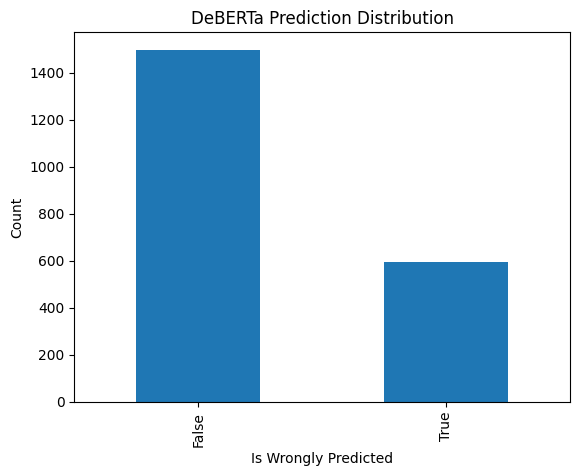

In [ ]:
testing_df_deberta["isWrongPrediction"].value_counts().plot(kind='bar', xlabel = 'Is Wrongly Predicted', ylabel = 'Count', title = 'DeBERTa Prediction Distribution')

Creating 2 new dataframes to separate the wrongly predicted instances and the correctly predicted instances

In [ ]:
wrong_predictions_df = testing_df_deberta[testing_df_deberta["isWrongPrediction"] == True] # misclassifications dataframe
true_predictions_df = testing_df_deberta[testing_df_deberta["isWrongPrediction"] == False] # correct classifications dataframe

In [ ]:
# check dataframe
wrong_predictions_df

,text,hypothesis,label,labels_id,deberta_predicted_labels,isWrongPrediction
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,1,0,True
5,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,All Confidential Information shall be expressl...,Contradiction,2,0,True
7,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may independently develop info...,Entailment,1,0,True
8,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may retain some Confidential I...,Entailment,1,2,True
11,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may share some Confidential In...,Entailment,1,2,True
...,...,...,...,...,...,...
2058,Exhibit (d)(2)\nMUTUAL NON-DISCLOSURE AGREEMEN...,Receiving Party shall destroy or return some C...,NotMentioned,0,1,True
2069,Exhibit (d)(2)\nMUTUAL NON-DISCLOSURE AGREEMEN...,Receiving Party may create a copy of some Conf...,Entailment,1,0,True
2073,Exhibit (d)(2)\nMUTUAL NON-DISCLOSURE AGREEMEN...,Receiving Party shall not use any Confidential...,Contradiction,2,1,True
2076,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Agreement shall not grant Receiving Party any ...,NotMentioned,0,1,True


In [ ]:
# now we'll get the texts and hypothesis of the misclassified and the correctly classified contracts
# to analyze their sequence lengths to check if there is a relation between either "text" or "hypothesis" length with the classification outcome

wrong_pred_text = wrong_predictions_df["text"] # getting the text of the wrongly predicted contracts
correct_pred_text = true_predictions_df["text"] # getting the text of the correctly predicted contracts

wrong_pred_hypo = wrong_predictions_df["hypothesis"] # getting the hypothesis of the wrongly predicted contracts
correct_pred_hypo = true_predictions_df["hypothesis"] # getting the hypothesis of the correctly predicted contracts

In [ ]:
# getting the mean number of words in each of the "text" and "hypothesis"
_, _,  average_words_in_wrong_pred_texts = words_per_contract(wrong_pred_text)
_, _,  average_words_in_wrong_pred_hypos = words_per_contract(wrong_pred_hypo)
_, _,  average_words_in_correct_pred_texts = words_per_contract(correct_pred_text)
_, _,  average_words_in_correct_pred_hypos = words_per_contract(correct_pred_hypo)

In [ ]:
texts = [average_words_in_wrong_pred_texts, average_words_in_correct_pred_texts]
hypos = [average_words_in_wrong_pred_hypos, average_words_in_correct_pred_hypos]
pred = ["Wrong", "Correct"]

# Create a dictionary
stats_dict = {'Prediction': pred,
            'Text Average Length': texts,
            'Hypothesis Average Length': hypos}

# Create a DataFrame from the dictionary
stats_df = pd.DataFrame(stats_dict)
stats_df = stats_df.set_index('Prediction')
stats_df

,Text Average Length,Hypothesis Average Length
Prediction,,
Wrong,1573.818182,13.232323
Correct,1762.389446,12.661323


Plotting "text" and "hypothesis" average length for both correctly classified and misclassified cases to see if there is a relation between them

<Axes: title={'center': 'DeBERTa Average Lengths Distribution'}, xlabel='Prediction'>

Text(0, 0.5, 'Average number of words')

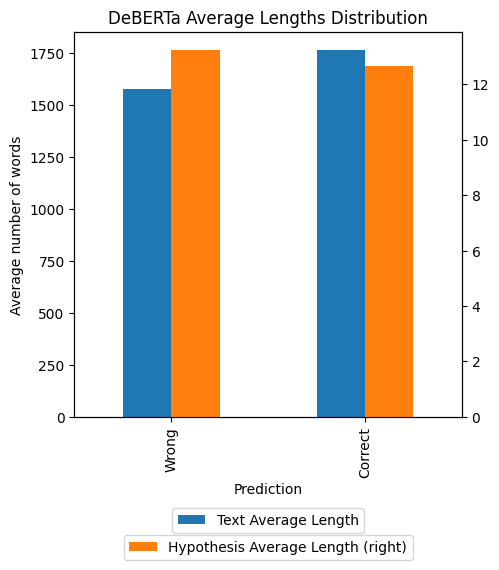

In [ ]:
stats_df.plot.bar(figsize=(5,5), secondary_y= 'Hypothesis Average Length', title = 'DeBERTa Average Lengths Distribution')
ax1, ax2 = plt.gcf().get_axes() # gets the current figure and then the axes
ax1.set_ylabel('Average number of words')
ax1.legend(loc = 'lower center', bbox_to_anchor = (0.5,-0.32,0,0))
ax2.legend(loc = 'lower center', bbox_to_anchor = (0.5,-0.39,0,0))

We can see that the average lengths of the "text" and the "hypothesis" are not varying much between the correctly classified and misclassified instances.

Also as we mentioned in the modeling section we set the maximum sequence length given to the tokenizer to be 512 which will make all the input sequences to have the same length so above sequence length comparison is not relevant to models performance.

However truncating the sequences to be 512 may have had a severe effect on the model's performance as the evidence spans or the relevant keywords for a specific label that can facilitate the classification may have appeared later in the sequence which unfortuantely became truncated so the text becomes ambiguous to the model leading to more misclassifications.

We tried to increase the max_len however increasing beyond 512 causes the RAM to crash during the runtime so we werent able to experiment with different max_len values.

Plotting the wrong and correct classifications distribution across the target labels to check which hypothesis label is mostly predicted wrong or correct

In [ ]:
wrong_pred_distribution = wrong_predictions_df['label'].value_counts()
correct_pred_distribution = true_predictions_df['label'].value_counts()

# Combine the two Series into a DataFrame
pred_distribution_df = pd.concat([correct_pred_distribution, wrong_pred_distribution, ], axis=1)
pred_distribution_df.columns = ["Correct Classifications", "Misclassifications"]

# Print the DataFrame
print(pred_distribution_df)

               Correct Classifications  Misclassifications
Entailment                         762                 206
NotMentioned                       596                 307
Contradiction                      139                  81


<Axes: title={'center': 'DeBERTa Classification Distribution'}, xlabel='Label', ylabel='Count'>

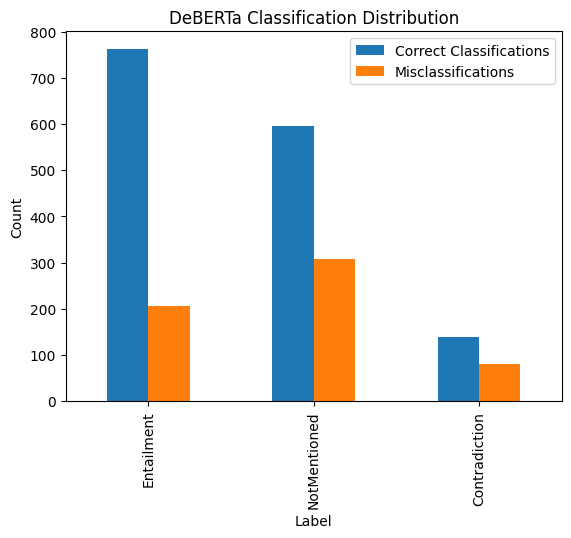

In [ ]:
pred_distribution_df.plot(kind='bar', title = "DeBERTa Classification Distribution",  xlabel = 'Label', ylabel = 'Count')

# wrong_predictions_df['label'].value_counts().plot(kind='bar', title = "Wrong Predictions Distribution",  xlabel = 'Label', ylabel = 'Wrong Predictions Count')
# true_predictions_df['label'].value_counts().plot(kind='bar', title = "Correct Predictions Distribution",  xlabel = 'Label', ylabel = 'Correct Predictions Count')

From the above curve we can see that the most misclassified label is the "NotMentioned" also one third of the "Contradiction" labels are misclassified.

We think these results are due to the severe truncation of the text that was made which lead to increased ambiguity and loss of context as truncating text can remove important context that is necessary for understanding the meaning of the text and consequently make good predictions which leads to increased difficulty for the model making it more difficult to learn the relationships between words and phrases which results in lower accuracy and performance.

For "Contradiction" label specifically as shown in below Figure-1 the class is under represented which may contribute to the increased errors for this label. As when we compare by the "Entailment" label having a larger number of diverse samples in the dataset helped to reduce the impact of text truncation. This is because the model will be exposed to a wider range of contexts, even if some of the text is truncated.

Figure-1 is a reference curve produced at Q1 showing the labels distribution in each dataset.

Figure-1

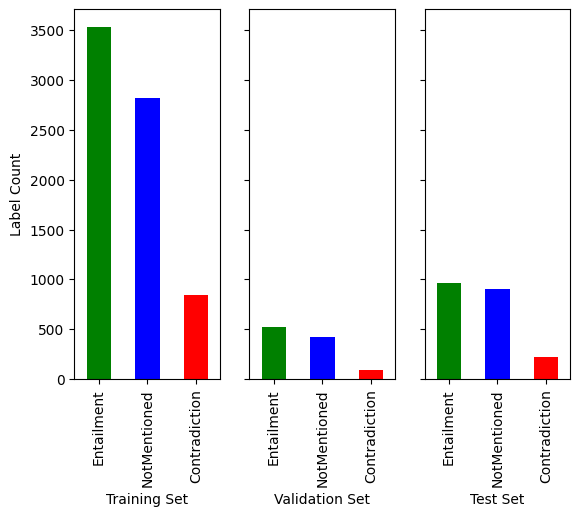



## Model 2 - DistilBERT (base-uncased)

Error Analysis Summary:

*   31.76% of contracts hypothesis labels are predicted wrongly.
*   Truncation of the input sequence to 512 had a bad effect on the model as relevant keywords for the labels are most probably truncated.
*   "NotMentioned" label is the most misclassified label.
*   ~50% of the "Contradiction" label are misclassified.
*    Bad performance on "Contradiction" can be due to its small presence in the training dataset as compared by "Entailment" label.
*   As discussed in the convergence curves section in Q2 we found that the optimal training epochs was 3 so there will be no benefit in training for more epochs.


Check testing dataframe current features

In [ ]:
testing_df.head()

,text,hypothesis,label
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction


Reading the saved testing data object of DistilBERT model that was saved during training

In [ ]:
# Reading saved data
with open('test_results_distilbert_4epochs512maxlen.pkl', 'rb') as f:
    distilbert_test_results = pk.load(f) # deserialize using load()
f.close()

Getting the predictions from the testing object

In [ ]:
distilbert_test_results.predictions

array([[ 2.288966  , -0.20065686, -2.208835  ],
       [ 1.818468  ,  0.03583536, -2.0828633 ],
       [-0.27117807,  2.1417477 , -1.7605114 ],
       ...,
       [-0.42641267,  2.2353754 , -1.7342427 ],
       [-0.4581638 ,  2.2474186 , -1.7253758 ],
       [-0.45771468,  2.247227  , -1.7269242 ]], dtype=float32)

In [ ]:
predictions = np.argmax(distilbert_test_results.predictions, axis=1)
predictions

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:
distilbert_test_results.label_ids
distilbert_test_results.metrics

array([0, 1, 1, ..., 1, 1, 1])

{'test_loss': 0.7579053044319153,
 'test_accuracy': 0.6824485891917743,
 'test_F1-Score': 0.6371431724019602,
 'test_Precision': 0.6538013415105716,
 'test_Recall': 0.6298039287468463,
 'test_runtime': 37.3042,
 'test_samples_per_second': 56.053,
 'test_steps_per_second': 14.02}

In [ ]:
f1_score(distilbert_test_results.label_ids, distilbert_predictions, average = 'macro')

0.6371431724019602

Creating new feature of DistilBERT predictions

In [ ]:
# Make a copy of the DataFrame
testing_df_distilbert = testing_df.copy()

In [ ]:
testing_df_distilbert["labels_id"] = distilbert_test_results.label_ids
testing_df_distilbert["distilbert_predicted_labels"] = predictions

In [ ]:
testing_df_distilbert.head()

,text,hypothesis,label,labels_id,distilbert_predicted_labels
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,0,0
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,1,0
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,1,1
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,0,0
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,2,2


Creating a new column to indicate whether the true label and the predicted label are matching or not

In [ ]:
testing_df_distilbert["isWrongPrediction"] = testing_df_distilbert["labels_id"] != testing_df_distilbert["distilbert_predicted_labels"] # True if they are not equal and False otherwise

In [ ]:
testing_df_distilbert.head()

,text,hypothesis,label,labels_id,distilbert_predicted_labels,isWrongPrediction
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,0,0,False
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,1,0,True
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,1,1,False
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,0,0,False
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,2,2,False


Checking how many wrong classifications are made

In [ ]:
print(round((testing_df_distilbert["isWrongPrediction"].value_counts(normalize =True)*100)[True], 2), "% of contracts hypothesis labels are predicted wrongly")

31.76 % of contracts hypothesis labels are predicted wrongly


<Axes: title={'center': 'DistilBERT Prediction Distribution'}, xlabel='Is Wrongly Predicted', ylabel='Count'>

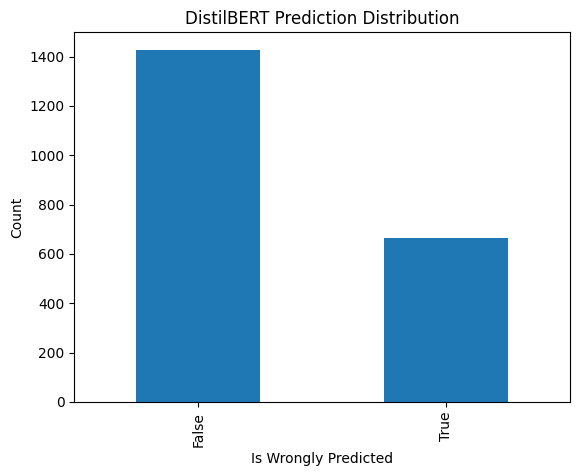

In [ ]:
testing_df_distilbert["isWrongPrediction"].value_counts().plot(kind='bar', xlabel = 'Is Wrongly Predicted', ylabel = 'Count', title = 'DistilBERT Prediction Distribution')

Creating 2 new dataframes to separate the wrongly predicted instances and the correctly predicted instances

In [ ]:
wrong_predictions_df = testing_df_distilbert[testing_df_distilbert["isWrongPrediction"] == True] # misclassifications dataframe
true_predictions_df = testing_df_distilbert[testing_df_distilbert["isWrongPrediction"] == False] # correct classifications dataframe

In [ ]:
# check dataframe
wrong_predictions_df

,text,hypothesis,label,labels_id,distilbert_predicted_labels,isWrongPrediction
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,1,0,True
5,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,All Confidential Information shall be expressl...,Contradiction,2,0,True
7,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may independently develop info...,Entailment,1,0,True
8,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may retain some Confidential I...,Entailment,1,2,True
9,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information may include verbally ...,NotMentioned,0,1,True
...,...,...,...,...,...,...
2069,Exhibit (d)(2)\nMUTUAL NON-DISCLOSURE AGREEMEN...,Receiving Party may create a copy of some Conf...,Entailment,1,0,True
2073,Exhibit (d)(2)\nMUTUAL NON-DISCLOSURE AGREEMEN...,Receiving Party shall not use any Confidential...,Contradiction,2,1,True
2075,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party shall destroy or return some C...,NotMentioned,0,1,True
2076,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Agreement shall not grant Receiving Party any ...,NotMentioned,0,1,True


In [ ]:
# now we'll get the texts and hypothesis of the misclassified and the correctly classified contracts
# to analyze their sequence lengths to check if there is a relation between either "text" or "hypothesis" length with the classification outcome

wrong_pred_text = wrong_predictions_df["text"] # getting the text of the wrongly predicted contracts
correct_pred_text = true_predictions_df["text"] # getting the text of the correctly predicted contracts

wrong_pred_hypo = wrong_predictions_df["hypothesis"] # getting the hypothesis of the wrongly predicted contracts
correct_pred_hypo = true_predictions_df["hypothesis"] # getting the hypothesis of the correctly predicted contracts

In [ ]:
# getting the mean number of words in each of the "text" and "hypothesis"
_, _,  average_words_in_wrong_pred_texts = words_per_contract(wrong_pred_text)
_, _,  average_words_in_wrong_pred_hypos = words_per_contract(wrong_pred_hypo)
_, _,  average_words_in_correct_pred_texts = words_per_contract(correct_pred_text)
_, _,  average_words_in_correct_pred_hypos = words_per_contract(correct_pred_hypo)

In [ ]:
texts = [average_words_in_wrong_pred_texts, average_words_in_correct_pred_texts]
hypos = [average_words_in_wrong_pred_hypos, average_words_in_correct_pred_hypos]
pred = ["Wrong", "Correct"]

# Create a dictionary
stats_dict = {'Prediction': pred,
            'Text Average Length': texts,
            'Hypothesis Average Length': hypos}

# Create a DataFrame from the dictionary
stats_df = pd.DataFrame(stats_dict)
stats_df = stats_df.set_index('Prediction')
stats_df

,Text Average Length,Hypothesis Average Length
Prediction,,
Wrong,1598.045181,12.902108
Correct,1760.366503,12.786966


Plotting "text" and "hypothesis" average length for both correctly classified and misclassified cases to see if there is a relation between them

<Axes: title={'center': 'DistilBERT Average Lengths Distribution'}, xlabel='Prediction'>

Text(0, 0.5, 'Average number of words')

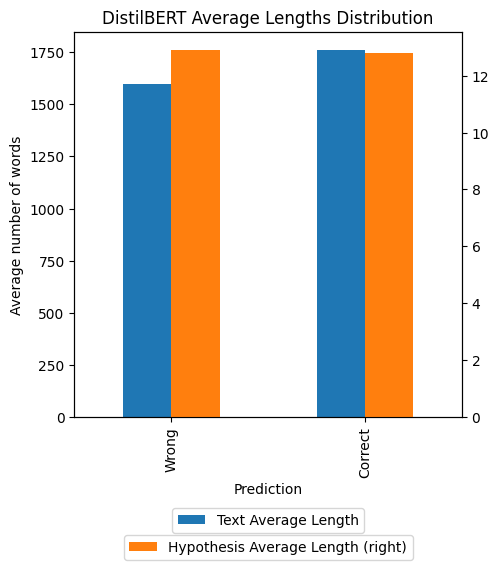

In [ ]:
stats_df.plot.bar(figsize=(5,5), secondary_y= 'Hypothesis Average Length',  title = 'DistilBERT Average Lengths Distribution')
ax1, ax2 = plt.gcf().get_axes() # gets the current figure and then the axes
ax1.set_ylabel('Average number of words')
ax1.legend(loc = 'lower center', bbox_to_anchor = (0.5,-0.32,0,0))
ax2.legend(loc = 'lower center', bbox_to_anchor = (0.5,-0.39,0,0))

We can see that the average lengths of the "text" and the "hypothesis" are not varying much between the correctly classified and misclassified instances.

Also as we mentioned in the modeling section we set the maximum sequence length given to the tokenizer to be 512 which will make all the input sequences to have the same length so above sequence length comparison is not relevant to models performance.

However truncating the sequences to be 512 may have had a severe effect on the model's performance as the evidence spans or the relevant keywords for a specific label that can facilitate the classification may have appeared later in the sequence which unfortuantely became truncated so the text becomes ambiguous to the model leading to more misclassifications.

We tried to increase the max_len however increasing beyond 512 causes the RAM to crash during the runtime so we werent able to experiment with different max_len values.

Plotting the wrong and correct classifications distribution across the target labels to check which hypothesis label is mostly predicted wrong or correct

In [ ]:
wrong_pred_distribution = wrong_predictions_df['label'].value_counts()
correct_pred_distribution = true_predictions_df['label'].value_counts()

# Combine the two Series into a DataFrame
pred_distribution_df = pd.concat([correct_pred_distribution, wrong_pred_distribution, ], axis=1)
pred_distribution_df.columns = ["Correct Classifications", "Misclassifications"]

# Print the DataFrame
print(pred_distribution_df)

               Correct Classifications  Misclassifications
Entailment                         790                 178
NotMentioned                       530                 373
Contradiction                      107                 113


<Axes: title={'center': 'DistilBERT Classification Distribution'}, xlabel='Label', ylabel='Count'>

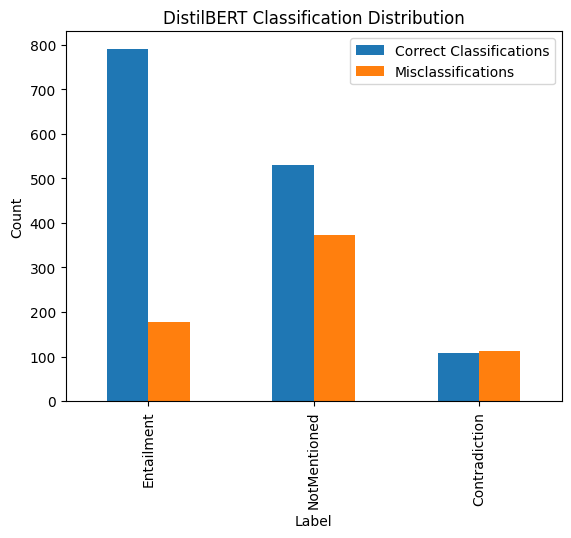

In [ ]:
pred_distribution_df.plot(kind='bar', title = "DistilBERT Classification Distribution",  xlabel = 'Label', ylabel = 'Count')

# wrong_predictions_df['label'].value_counts().plot(kind='bar', title = "Wrong Predictions Distribution",  xlabel = 'Label', ylabel = 'Wrong Predictions Count')
# true_predictions_df['label'].value_counts().plot(kind='bar', title = "Correct Predictions Distribution",  xlabel = 'Label', ylabel = 'Correct Predictions Count')

From the above curve we can see that the most misclassified label is the "NotMentioned" also 50% of the "Contradiction" labels are misclassified which is very bad as it has the performance of a random classifier on this label.

We think these results are due to the severe truncation of the text that was made which lead to increased ambiguity and loss of context as truncating text can remove important context that is necessary for understanding the meaning of the text and consequently make good predictions which leads to increased difficulty for the model making it more difficult to learn the relationships between words and phrases which results in lower accuracy and performance.

For "Contradiction" label specifically as shown in below Figure-1 the class is under represented which may contribute to the increased errors for this label. As when we compare by the "Entailment" label having a larger number of diverse samples in the dataset helped to reduce the impact of text truncation. This is because the model will be exposed to a wider range of contexts, even if some of the text is truncated.

Figure-1 is a reference curve produced at Q1 showing the labels distribution in each dataset.

Figure-1

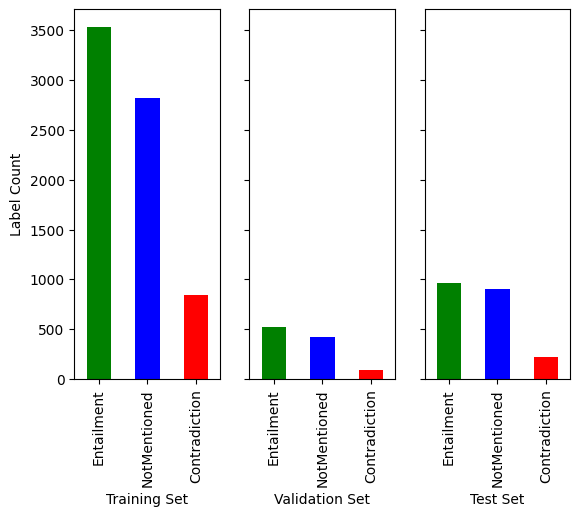



To Improve the performance we can try the following:

1.   Fine tune the model for more epochs if applicable in accordance to the recommendations of the model authors.
2.   Try to increase the maximum sequence length as much as possible to capture all needed context such that text truncation to have a minimal impact, however this needs more HW capability.
3.   Try to have a larger number of samples in the dataset for each label because as we have seen in case of "Entailment" label, having a large number of samples helped to reduce the impact of text truncation. This is because the model will be exposed to a wider range of contexts, even if some of the text is truncated.
4.   Try to choose the pre-trained models carefully to avoid domain mismatch issue in which The NLI model used may be trained on a dataset of text that is different from the text that it is being asked to classify which leads to misclassification, as the model may not be familiar with the vocabulary or grammar of the new dataset.
5.   Try to perform a more rigorous text preprocessing than that is made by default by the tokenizers such that we guarantee that the text is clean as much as possible.







# Appendix

In [ ]:
import json
import pandas as pd

data = json.load(open('/content/dev.json'))

documents = pd.DataFrame(data['documents'])
nda_data = pd.DataFrame(data['labels']).transpose()


In [ ]:
documents.head(3)

,id,file_name,text,spans,annotation_sets,document_type,url
0,3,09-24-2019-04-25-05-3914910473.pdf,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,"[[0, 14], [15, 67], [68, 127], [128, 282], [28...",[{'annotations': {'nda-11': {'choice': 'Entail...,search-pdf,https://www.oisair.net/uploads/pages/09-24-201...
1,7,1438076025NDA_28072015%20-%20AHPL.pdf,NON-DISCLOSURE AGREEMENT\nTHIS AGREEMENT is ma...,"[[0, 24], [25, 40], [40, 72], [72, 101], [101,...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,https://www.ktph.com.sg/uploads/1438076025NDA_...
2,9,17.04.01%20BPS%20Non-Disclosure%20and%20Data%2...,NON-NEGOTIABLE CONFIDENTIALITY AND NON-DISCLOS...,"[[0, 90], [91, 186], [186, 440], [441, 584], [...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,https://www.bostonpublicschools.org/cms/lib/MA...


In [ ]:
documents.iloc[2]

id                                                                 9
file_name          17.04.01%20BPS%20Non-Disclosure%20and%20Data%2...
text               NON-NEGOTIABLE CONFIDENTIALITY AND NON-DISCLOS...
spans              [[0, 90], [91, 186], [186, 440], [441, 584], [...
annotation_sets    [{'annotations': {'nda-11': {'choice': 'NotMen...
document_type                                             search-pdf
url                https://www.bostonpublicschools.org/cms/lib/MA...
Name: 2, dtype: object

In [ ]:
documents.iloc[2]['annotation_sets']

[{'annotations': {'nda-11': {'choice': 'NotMentioned', 'spans': []},
   'nda-16': {'choice': 'Entailment', 'spans': [77]},
   'nda-15': {'choice': 'NotMentioned', 'spans': []},
   'nda-10': {'choice': 'NotMentioned', 'spans': []},
   'nda-2': {'choice': 'Entailment', 'spans': [16]},
   'nda-1': {'choice': 'NotMentioned', 'spans': []},
   'nda-19': {'choice': 'Entailment', 'spans': [95]},
   'nda-12': {'choice': 'NotMentioned', 'spans': []},
   'nda-20': {'choice': 'NotMentioned', 'spans': []},
   'nda-3': {'choice': 'NotMentioned', 'spans': []},
   'nda-18': {'choice': 'NotMentioned', 'spans': []},
   'nda-7': {'choice': 'Contradiction', 'spans': [13]},
   'nda-17': {'choice': 'NotMentioned', 'spans': []},
   'nda-8': {'choice': 'Entailment', 'spans': [64]},
   'nda-13': {'choice': 'NotMentioned', 'spans': []},
   'nda-5': {'choice': 'Contradiction', 'spans': [13]},
   'nda-4': {'choice': 'Entailment', 'spans': [57, 58]}}}]

In [ ]:
documents.iloc[2]['annotation_sets'][0]['annotations']

{'nda-11': {'choice': 'NotMentioned', 'spans': []},
 'nda-16': {'choice': 'Entailment', 'spans': [77]},
 'nda-15': {'choice': 'NotMentioned', 'spans': []},
 'nda-10': {'choice': 'NotMentioned', 'spans': []},
 'nda-2': {'choice': 'Entailment', 'spans': [16]},
 'nda-1': {'choice': 'NotMentioned', 'spans': []},
 'nda-19': {'choice': 'Entailment', 'spans': [95]},
 'nda-12': {'choice': 'NotMentioned', 'spans': []},
 'nda-20': {'choice': 'NotMentioned', 'spans': []},
 'nda-3': {'choice': 'NotMentioned', 'spans': []},
 'nda-18': {'choice': 'NotMentioned', 'spans': []},
 'nda-7': {'choice': 'Contradiction', 'spans': [13]},
 'nda-17': {'choice': 'NotMentioned', 'spans': []},
 'nda-8': {'choice': 'Entailment', 'spans': [64]},
 'nda-13': {'choice': 'NotMentioned', 'spans': []},
 'nda-5': {'choice': 'Contradiction', 'spans': [13]},
 'nda-4': {'choice': 'Entailment', 'spans': [57, 58]}}

In [ ]:
documents.iloc[2]['annotation_sets'][0]['annotations']['nda-11']

{'choice': 'NotMentioned', 'spans': []}

In [ ]:
documents.iloc[2]['annotation_sets'][0]['annotations']['nda-11']['choice']

'NotMentioned'

In [ ]:
documents['annotation_sets']

0     [{'annotations': {'nda-11': {'choice': 'Entail...
1     [{'annotations': {'nda-11': {'choice': 'NotMen...
2     [{'annotations': {'nda-11': {'choice': 'NotMen...
3     [{'annotations': {'nda-11': {'choice': 'NotMen...
4     [{'annotations': {'nda-11': {'choice': 'NotMen...
                            ...                        
56    [{'annotations': {'nda-11': {'choice': 'Entail...
57    [{'annotations': {'nda-11': {'choice': 'NotMen...
58    [{'annotations': {'nda-11': {'choice': 'NotMen...
59    [{'annotations': {'nda-11': {'choice': 'NotMen...
60    [{'annotations': {'nda-11': {'choice': 'NotMen...
Name: annotation_sets, Length: 61, dtype: object

In [ ]:
documents['annotation'] = documents['annotation_sets'].apply(lambda annot_as_list: annot_as_list[0]['annotations'])

In [ ]:
documents['annotation']

0     {'nda-11': {'choice': 'Entailment', 'spans': [...
1     {'nda-11': {'choice': 'NotMentioned', 'spans':...
2     {'nda-11': {'choice': 'NotMentioned', 'spans':...
3     {'nda-11': {'choice': 'NotMentioned', 'spans':...
4     {'nda-11': {'choice': 'NotMentioned', 'spans':...
                            ...                        
56    {'nda-11': {'choice': 'Entailment', 'spans': [...
57    {'nda-11': {'choice': 'NotMentioned', 'spans':...
58    {'nda-11': {'choice': 'NotMentioned', 'spans':...
59    {'nda-11': {'choice': 'NotMentioned', 'spans':...
60    {'nda-11': {'choice': 'NotMentioned', 'spans':...
Name: annotation, Length: 61, dtype: object

In [ ]:
documents['annotation'][0]

{'nda-11': {'choice': 'Entailment', 'spans': [33, 39]},
 'nda-16': {'choice': 'Entailment', 'spans': [47]},
 'nda-15': {'choice': 'Entailment', 'spans': [51]},
 'nda-10': {'choice': 'Entailment', 'spans': [89, 90]},
 'nda-2': {'choice': 'Contradiction', 'spans': [17]},
 'nda-1': {'choice': 'Entailment', 'spans': [18]},
 'nda-19': {'choice': 'Entailment', 'spans': [65]},
 'nda-12': {'choice': 'Entailment', 'spans': [25, 29]},
 'nda-20': {'choice': 'Entailment', 'spans': [48]},
 'nda-3': {'choice': 'Entailment', 'spans': [18]},
 'nda-18': {'choice': 'NotMentioned', 'spans': []},
 'nda-7': {'choice': 'Entailment', 'spans': [23, 43]},
 'nda-17': {'choice': 'Entailment', 'spans': [48]},
 'nda-8': {'choice': 'NotMentioned', 'spans': []},
 'nda-13': {'choice': 'Entailment', 'spans': [25, 28]},
 'nda-5': {'choice': 'Entailment', 'spans': [23, 43]},
 'nda-4': {'choice': 'Entailment', 'spans': [12, 13, 33, 36]}}

In [ ]:
documents.head(3)

,id,file_name,text,spans,annotation_sets,document_type,url,annotation
0,3,09-24-2019-04-25-05-3914910473.pdf,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,"[[0, 14], [15, 67], [68, 127], [128, 282], [28...",[{'annotations': {'nda-11': {'choice': 'Entail...,search-pdf,https://www.oisair.net/uploads/pages/09-24-201...,"{'nda-11': {'choice': 'Entailment', 'spans': [..."
1,7,1438076025NDA_28072015%20-%20AHPL.pdf,NON-DISCLOSURE AGREEMENT\nTHIS AGREEMENT is ma...,"[[0, 24], [25, 40], [40, 72], [72, 101], [101,...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,https://www.ktph.com.sg/uploads/1438076025NDA_...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
2,9,17.04.01%20BPS%20Non-Disclosure%20and%20Data%2...,NON-NEGOTIABLE CONFIDENTIALITY AND NON-DISCLOS...,"[[0, 90], [91, 186], [186, 440], [441, 584], [...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,https://www.bostonpublicschools.org/cms/lib/MA...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."


In [ ]:
columns_to_drop = list(documents.columns)
#columns_to_drop.remove('annotation')
columns_to_drop

['id',
 'file_name',
 'text',
 'spans',
 'annotation_sets',
 'document_type',
 'url',
 'annotation']

In [ ]:
columns_to_drop.remove('text')
columns_to_drop.remove('annotation')

In [ ]:
columns_to_drop

['id', 'file_name', 'spans', 'annotation_sets', 'document_type', 'url']

In [ ]:
documents_short = documents.drop(columns_to_drop ,  axis=1)

In [ ]:
documents_short

,text,annotation
0,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,"{'nda-11': {'choice': 'Entailment', 'spans': [..."
1,NON-DISCLOSURE AGREEMENT\nTHIS AGREEMENT is ma...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
2,NON-NEGOTIABLE CONFIDENTIALITY AND NON-DISCLOS...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
3,CONFIDENTIALITY AND NON-DISCLOSURE AGREEMENT (...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
4,CONFIDENTIALITY (NON-DISCLOSURE) AGREEMENT\nTh...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
...,...,...
56,Exhibit (d)(3)\nNON-DISCLOSURE AGREEMENT\nIn c...,"{'nda-11': {'choice': 'Entailment', 'spans': [..."
57,"Exhibit (e)(5)\nMarch 17, 2010\nFLIR Systems, ...","{'nda-11': {'choice': 'NotMentioned', 'spans':..."
58,CONFIDENTIALITY AGREEMENT\nThis agreement ente...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
59,NON-DISCLOSURE AGREEMENT\n1. Introduction. Thi...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."


In [ ]:
df1 = (pd.DataFrame(documents_short['annotation'].values.tolist())).stack()
df1

0   nda-11          {'choice': 'Entailment', 'spans': [33, 39]}
    nda-16              {'choice': 'Entailment', 'spans': [47]}
    nda-15              {'choice': 'Entailment', 'spans': [51]}
    nda-10          {'choice': 'Entailment', 'spans': [89, 90]}
    nda-2            {'choice': 'Contradiction', 'spans': [17]}
                                    ...                        
60  nda-17              {'choice': 'NotMentioned', 'spans': []}
    nda-8           {'choice': 'Entailment', 'spans': [28, 29]}
    nda-13    {'choice': 'Entailment', 'spans': [12, 15, 16,...
    nda-5            {'choice': 'Entailment', 'spans': [5, 20]}
    nda-4        {'choice': 'Contradiction', 'spans': [19, 46]}
Length: 1037, dtype: object

In [ ]:
df1 = df1.reset_index(level=1).rename(columns={0:'nda_dict', 'level_1':'nda-num'})
df1

,nda-num,nda_dict
0,nda-11,"{'choice': 'Entailment', 'spans': [33, 39]}"
0,nda-16,"{'choice': 'Entailment', 'spans': [47]}"
0,nda-15,"{'choice': 'Entailment', 'spans': [51]}"
0,nda-10,"{'choice': 'Entailment', 'spans': [89, 90]}"
0,nda-2,"{'choice': 'Contradiction', 'spans': [17]}"
...,...,...
60,nda-17,"{'choice': 'NotMentioned', 'spans': []}"
60,nda-8,"{'choice': 'Entailment', 'spans': [28, 29]}"
60,nda-13,"{'choice': 'Entailment', 'spans': [12, 15, 16,..."
60,nda-5,"{'choice': 'Entailment', 'spans': [5, 20]}"


In [ ]:
df2 = documents_short.drop('annotation', axis=1).join(df1).reset_index(drop=True)
df2

,text,nda-num,nda_dict
0,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-11,"{'choice': 'Entailment', 'spans': [33, 39]}"
1,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-16,"{'choice': 'Entailment', 'spans': [47]}"
2,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-15,"{'choice': 'Entailment', 'spans': [51]}"
3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-10,"{'choice': 'Entailment', 'spans': [89, 90]}"
4,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-2,"{'choice': 'Contradiction', 'spans': [17]}"
...,...,...,...
1032,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,nda-17,"{'choice': 'NotMentioned', 'spans': []}"
1033,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,nda-8,"{'choice': 'Entailment', 'spans': [28, 29]}"
1034,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,nda-13,"{'choice': 'Entailment', 'spans': [12, 15, 16,..."
1035,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,nda-5,"{'choice': 'Entailment', 'spans': [5, 20]}"


In [ ]:
df2['label'] = df2['nda_dict'].apply(lambda nda_dict: nda_dict['choice'])

In [ ]:
df2.drop(['nda_dict'], axis=1, inplace=True)

In [ ]:
df2

,text,nda-num,label
0,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-11,Entailment
1,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-16,Entailment
2,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-15,Entailment
3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-10,Entailment
4,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-2,Contradiction
...,...,...,...
1032,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,nda-17,NotMentioned
1033,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,nda-8,Entailment
1034,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,nda-13,Entailment
1035,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,nda-5,Entailment


In [ ]:
nda_data = pd.DataFrame(data['labels']).transpose()
nda_data

,short_description,hypothesis
nda-11,No reverse engineering,Receiving Party shall not reverse engineer any...
nda-16,Return of confidential information,Receiving Party shall destroy or return some C...
nda-15,No licensing,Agreement shall not grant Receiving Party any ...
nda-10,Confidentiality of Agreement,Receiving Party shall not disclose the fact th...
nda-2,None-inclusion of non-technical information,Confidential Information shall only include te...
nda-1,Explicit identification,All Confidential Information shall be expressl...
nda-19,Survival of obligations,Some obligations of Agreement may survive term...
nda-12,Permissible development of similar information,Receiving Party may independently develop info...
nda-20,Permissible post-agreement possession,Receiving Party may retain some Confidential I...
nda-3,Inclusion of verbally conveyed information,Confidential Information may include verbally ...


In [ ]:
nda_data = nda_data.reset_index(names=['nda-num'])
nda_data

,nda-num,short_description,hypothesis
0,nda-11,No reverse engineering,Receiving Party shall not reverse engineer any...
1,nda-16,Return of confidential information,Receiving Party shall destroy or return some C...
2,nda-15,No licensing,Agreement shall not grant Receiving Party any ...
3,nda-10,Confidentiality of Agreement,Receiving Party shall not disclose the fact th...
4,nda-2,None-inclusion of non-technical information,Confidential Information shall only include te...
5,nda-1,Explicit identification,All Confidential Information shall be expressl...
6,nda-19,Survival of obligations,Some obligations of Agreement may survive term...
7,nda-12,Permissible development of similar information,Receiving Party may independently develop info...
8,nda-20,Permissible post-agreement possession,Receiving Party may retain some Confidential I...
9,nda-3,Inclusion of verbally conveyed information,Confidential Information may include verbally ...


In [ ]:
# Merging the dataframes
final_df = pd.merge(df2, nda_data, on = 'nda-num', how = 'left')

In [ ]:
final_df

,text,nda-num,label,short_description,hypothesis
0,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-11,Entailment,No reverse engineering,Receiving Party shall not reverse engineer any...
1,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-16,Entailment,Return of confidential information,Receiving Party shall destroy or return some C...
2,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-15,Entailment,No licensing,Agreement shall not grant Receiving Party any ...
3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-10,Entailment,Confidentiality of Agreement,Receiving Party shall not disclose the fact th...
4,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,nda-2,Contradiction,None-inclusion of non-technical information,Confidential Information shall only include te...
...,...,...,...,...,...
1032,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,nda-17,NotMentioned,Permissible copy,Receiving Party may create a copy of some Conf...
1033,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,nda-8,Entailment,Notice on compelled disclosure,Receiving Party shall notify Disclosing Party ...
1034,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,nda-13,Entailment,Permissible acquirement of similar information,Receiving Party may acquire information simila...
1035,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,nda-5,Entailment,Sharing with employees,Receiving Party may share some Confidential In...


In [ ]:
final_df.drop(['nda-num', 'short_description'], axis=1, inplace=True)

In [ ]:
final_df

,text,label,hypothesis
0,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Entailment,Receiving Party shall not reverse engineer any...
1,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Entailment,Receiving Party shall destroy or return some C...
2,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Entailment,Agreement shall not grant Receiving Party any ...
3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Entailment,Receiving Party shall not disclose the fact th...
4,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Contradiction,Confidential Information shall only include te...
...,...,...,...
1032,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,NotMentioned,Receiving Party may create a copy of some Conf...
1033,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,Entailment,Receiving Party shall notify Disclosing Party ...
1034,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,Entailment,Receiving Party may acquire information simila...
1035,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,Entailment,Receiving Party may share some Confidential In...
